# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,59 mins 03 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_navdeep_viinc1
H2O cluster total nodes:,1
H2O cluster free memory:,28.25 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (160338, 24)
Test shape: (39662, 23)


In [5]:
train.head()

Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
2.5493e+06,0,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1,False,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.0403074,0.854601
4.00076e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5,False,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.0181326,-0.425131
1.54693e+06,0,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5,False,-0.778227,0.228996,-4.09175,4.61086,-0.720941,-0.0323383,0.123326
5.45314e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,False,-0.0746695,-1.15024,0.244394,-0.215304,0.358276,-0.0181326,-0.425131
4.94313e+06,0,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4,False,-0.602338,0.55252,0.244394,-0.215304,-0.628437,-0.0382285,0.763191
1.23729e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,False,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.0247158,0.397554
682016,0,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1,False,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.0209045,1.03742
19740,0,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2,False,-0.734255,0.55252,0.244394,-0.215304,-0.720941,-0.0396144,0.488963
5.36388e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5,False,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.0319161
1.94229e+06,0,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4,False,1.33245,-0.261719,0.244394,-0.215304,1.19082,0.0757636,-1.15641


In [6]:
train.summary()

,Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum,real,real,real,real,real,real,real
mins,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,-1.26192360553821,-3.4792433327941232,-4.09174686250922,-0.21530422241413488,-1.0909583443261746,-0.09782313461197675,-2.527546647809547
mean,3319386.4112125635,0.09670196709451284,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353815,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.003037333632701,,8.938396999015344e-17,-3.775663977769495e-17,1.3400948202787506e-16,-4.254269270726192e-18,-1.063567317681548e-18,0.0,-2.7510941284029374e-16
maxs,6504996.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,,51.50492551541175,202.75528359110467,0.24439439525512616,16.877348931294414,40.8443375990408,305.5429652264891,3.87111034635691
sigma,1952820.8522752034,0.295552434347859,0.1951890799460008,0.25844393424533546,0.2693609245488,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.4117503573990468,0.4117503573990468,1.41151976175012,,1.0000031184269407,1.0000031184269407,1.0000031184269407,1.0000031184269407,1.0000031184269405,1.000003118426941,1.0000031184269407
zeros,0,144833,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0,,0,0,0,0,0,0,0
missing,0,0,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0,0,0,0,0,0,0,0,0
0,2549300.0,0.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0,False,-0.5143932429914191,0.3339223958668174,0.24439439525512616,-0.21530422241413488,-0.5359323686051412,-0.04030738198147695,0.8546006205355803
1,4000757.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0,False,-0.11864187458429434,0.26872662571185846,0.24439439525512616,-0.21530422241413488,-0.22758460431567815,-0.018132633979356542,-0.4251307782977112
2,1546928.0,0.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0,False,-0.7782274885961689,0.228995556370366,-4.09174686250922,4.610856668044749,-0.720941027178819,-0.03233833191821493,0.12332553548798514


In [7]:
test.head()

Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
131497,0,1,1,0,1,0,0,0,1,0,1,0,nan,nan,False,-0.470421,0.345133,0.244394,-0.215304,-0.505098,-0.0080847,-2.52755
851117,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.321082,0.342439,-4.09175,3.20323,0.0807632,-0.0108565,-1.15641
835616,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,-0.118642,0.55252,0.244394,-0.215304,-0.289254,-0.0160538,1.03742
121491,0,0,1,0,0,1,0,0,0,1,1,0,1,0,False,-0.64631,-1.19197,0.244394,-0.215304,-0.320089,-0.02922,0.0319161
4.47964e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,0,1,False,0.277109,0.336837,0.244394,-0.215304,0.0499284,0.00057731,0.763191
843194,1,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,False,0.321082,0.444679,0.244394,-0.215304,0.0499284,-0.0351102,3.87111
6.37726e+06,0,1,1,0,0,1,0,0,0,1,0,1,nan,nan,False,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.0340707,1.58588
5.25537e+06,0,1,1,0,0,1,0,0,1,0,0,1,nan,nan,False,-0.690283,-0.182763,0.244394,-0.215304,-0.597602,-0.0247158,0.94601
4.59782e+06,0,1,1,0,1,0,0,0,0,1,1,0,nan,nan,False,0.716833,-0.682306,-4.09175,4.61086,0.913302,-0.0243693,0.306144
6.13819e+06,0,1,1,0,0,1,0,0,0,1,nan,nan,1,0,False,0.145192,-0.246306,0.244394,-0.215304,0.142433,-0.0302594,1.03742


In [8]:
test.summary()

,Unnamed: 0,high_priced,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum,real,real,real,real,real,real,real
mins,4056.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,-1.26192360553821,-3.4586567959595325,-4.09174686250922,-0.21530422241413488,-1.029288791468282,-0.05278067773266968,-2.527546647809547
mean,3323235.642428521,0.09752407846301246,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092,,0.004096505679623418,-0.00846253655870321,-0.010447651839036788,0.0055571501904296584,0.005967330951646153,0.010591915149438086,-0.007259301127656858
maxs,6504997.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,,19.05331330602753,37.75782848293456,0.24439439525512616,14.263178448962517,27.40037507602021,137.15347258538733,3.87111034635691
sigma,1954622.3871122967,0.29667381367158185,0.19551834219733183,0.26144614833636154,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798,,0.9853674098950168,0.6456480788175912,1.0198592403214601,0.9844019248509008,0.9922639123326747,1.2475615471305674,0.9950299052385418
zeros,0,35794,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431,,0,0,0,0,0,0,0
missing,0,0,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582,0,0,0,0,0,0,0,0
0,131497.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan,False,-0.4704208687239607,0.3451325282916518,0.24439439525512616,-0.21530422241413488,-0.5050975921761949,-0.00808470129089574,-2.527546647809547
1,851117.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan,False,0.32108186809028866,0.3424391847869839,-4.09174686250922,3.2032264083275748,0.08076315997378489,-0.01085654479116079,-1.1564058633453065
2,835616.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0,False,-0.11864187458429434,0.5525199781510916,0.24439439525512616,-0.21530422241413488,-0.2892541571735708,-0.01605375135415776,1.037419391797479


In [9]:
# Inputs and output
X = ['term_360',
'conforming',
'debt_to_income_ratio_missing',
'loan_amount_std',
'loan_to_value_ratio_std',
'no_intro_rate_period_std',
'intro_rate_period_std',
'property_value_std',
'income_std',
'debt_to_income_ratio_std']
fold_column = 'cv_fold'
Y = 'high_priced'

In [10]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [11]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [12]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [13]:
# Default H2O ANN
ann = H2ODeepLearningEstimator(
               seed=SEED)
ann.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [14]:
ann

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1576105852299_1


Status of Neuron Layers: predicting high_priced, 2-class classification, bernoulli distribution, CrossEntropy loss, 43,202 weights/biases, 517.3 KB, 1,798,093 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,12,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,0.100557,0.268744,0,-0.08318,0.427479,0.250402,0.382997
2,,3,200,Rectifier,0,0,0,0.337429,0.377342,0,-0.0483146,0.111739,0.54082,0.317046
3,,4,2,Softmax,,0,0,0.011674,0.0256618,0,-0.0139884,0.308374,-0.0435881,0.991553




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.07834007129692257
RMSE: 0.27989296400038816
LogLoss: 0.26238189401082646
Mean Per-Class Error: 0.2388047443677923
AUC: 0.8151578286102898
pr_auc: 0.27210951696404084
Gini: 0.6303156572205797

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14610178345371544: 


,,0,1,Error,Rate
0,0,6761.0,2137.0,0.2402,(2137.0/8898.0)
1,1,275.0,700.0,0.2821,(275.0/975.0)
2,Total,7036.0,2837.0,0.2443,(2412.0/9873.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.146102,0.367261,225.0
1,max f2,0.079073,0.540885,288.0
2,max f0point5,0.234307,0.313996,148.0
3,max accuracy,0.663193,0.901246,0.0
4,max precision,0.663193,0.500000,0.0
5,max recall,0.000147,1.000000,399.0
6,max specificity,0.663193,0.999888,0.0
7,max absolute_mcc,0.102893,0.322222,265.0
8,max min_per_class_accuracy,0.137157,0.741538,233.0
9,max mean_per_class_accuracy,0.078264,0.761195,289.0



Gains/Lift Table: Avg response rate:  9.88 %, avg score:  9.55 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010027,3.933411e-01,4.091375,4.091375,0.404040,0.445060,0.404040,0.445060,0.041026,0.041026,309.137529,309.137529
1,,2,0.020055,3.655863e-01,2.863963,3.477669,0.282828,0.377258,0.343434,0.411159,0.028718,0.069744,186.396270,247.766900
2,,3,0.030082,3.469249e-01,3.170816,3.375385,0.313131,0.354730,0.333333,0.392349,0.031795,0.101538,217.081585,237.538462
3,,4,0.040008,3.326025e-01,2.789859,3.230115,0.275510,0.340643,0.318987,0.379521,0.027692,0.129231,178.985871,223.011490
4,,5,0.050035,3.214243e-01,2.761678,3.136238,0.272727,0.326877,0.309717,0.368971,0.027692,0.156923,176.167832,213.623793
5,,6,0.100071,2.735668e-01,2.992750,3.064494,0.295547,0.296977,0.302632,0.332974,0.149744,0.306667,199.274992,206.449393
6,,7,0.150005,2.337683e-01,2.772882,2.967421,0.273834,0.253067,0.293045,0.306374,0.138462,0.445128,177.288188,196.742118
7,,8,0.200041,1.983775e-01,2.193317,2.773797,0.216599,0.216017,0.273924,0.283773,0.109744,0.554872,119.331672,177.379708
8,,9,0.300111,1.383509e-01,1.824348,2.457207,0.180162,0.167821,0.242659,0.245110,0.182564,0.737436,82.434756,145.720709
9,,10,0.400081,7.822130e-02,1.343998,2.179046,0.132725,0.107578,0.215190,0.210744,0.134359,0.871795,34.399813,117.904576




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.07756714205865015
RMSE: 0.27850878273162255
LogLoss: 0.2633486013121568
Mean Per-Class Error: 0.25073636844826297
AUC: 0.8045795198038058
pr_auc: 0.2646231855400432
Gini: 0.6091590396076116

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16069184762287478: 


,,0,1,Error,Rate
0,0,111963.0,32870.0,0.227,(32870.0/144833.0)
1,1,5110.0,10395.0,0.3296,(5110.0/15505.0)
2,Total,117073.0,43265.0,0.2369,(37980.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160692,0.353752,217.0
1,max f2,0.098009,0.522931,276.0
2,max f0point5,0.229350,0.293501,150.0
3,max accuracy,0.532300,0.903360,22.0
4,max precision,0.532300,0.544643,22.0
5,max recall,0.000159,1.000000,399.0
6,max specificity,0.909950,0.999993,0.0
7,max absolute_mcc,0.115446,0.304120,260.0
8,max min_per_class_accuracy,0.141794,0.735247,236.0
9,max mean_per_class_accuracy,0.096765,0.749264,277.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.36 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,3.564109e-01,4.033332,4.033332,0.390031,0.409511,0.390031,0.409511,0.040374,0.040374,303.333215,303.333215
1,,2,0.020001,3.284539e-01,3.485748,3.759796,0.337079,0.341105,0.363580,0.375340,0.034827,0.075202,248.574762,275.979600
2,,3,0.030005,3.092992e-01,3.223520,3.581000,0.311721,0.318248,0.346290,0.356305,0.032248,0.107449,222.351972,258.100009
3,,4,0.040009,2.952745e-01,2.836697,3.394895,0.274314,0.301841,0.328293,0.342687,0.028378,0.135827,183.669736,239.489540
4,,5,0.050001,2.839689e-01,2.730502,3.262133,0.264045,0.289275,0.315455,0.332014,0.027282,0.163109,173.050230,226.213280
5,,6,0.100014,2.450600e-01,2.713253,2.987658,0.262377,0.263152,0.288912,0.297579,0.135698,0.298807,171.325251,198.765843
6,,7,0.150002,2.177293e-01,2.419148,2.798202,0.233936,0.230966,0.270592,0.275380,0.120929,0.419736,141.914799,179.820222
7,,8,0.200002,1.934465e-01,2.231510,2.656529,0.215791,0.205308,0.256892,0.257862,0.111577,0.531312,123.151038,165.652926
8,,9,0.300016,1.457376e-01,1.908155,2.407050,0.184522,0.169964,0.232767,0.228560,0.190842,0.722154,90.815482,140.705037
9,,10,0.399999,9.271752e-02,1.277876,2.124805,0.123573,0.119083,0.205473,0.201196,0.127765,0.849919,27.787553,112.480508




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7720838,0.016609553,0.79135656,0.76703334,0.7507333,0.7650339,0.7862619
1,auc,0.8070705,0.0033250789,0.8019743,0.80846965,0.8056047,0.8102921,0.8090116
2,err,0.2279162,0.016609553,0.20864344,0.23296669,0.24926668,0.23496607,0.21373808
3,err_count,7308.6,532.01953,6672.0,7413.0,7988.0,7584.0,6886.0
4,f0point5,0.28099382,0.010270916,0.2849402,0.288562,0.26672524,0.27395266,0.29078898
5,f1,0.35703802,0.008164277,0.35423926,0.36754543,0.34727895,0.35301143,0.36311504
6,f2,0.49024463,0.014816755,0.46807858,0.50606143,0.49754155,0.49621066,0.48333088
7,lift_top_group,3.9583843,0.2587289,4.0987425,3.7558537,3.810624,3.7777157,4.348985
8,logloss,0.26336312,0.0048042904,0.26557994,0.2685286,0.25967246,0.25702882,0.2660058
9,max_per_class_error,0.34576344,0.044011563,0.40429688,0.32412928,0.30075684,0.31985536,0.37977883



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-11 15:12:44,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-12-11 15:12:47,1 min 44.351 sec,37620 obs/sec,0.624350,1,100107.0,0.281291,0.268295,0.110979,0.807529,0.266283,3.273100,0.193761
2,,2019-12-11 15:12:52,1 min 49.542 sec,64101 obs/sec,3.111146,5,498835.0,0.280263,0.263246,0.117464,0.812824,0.265981,3.273100,0.238225
3,,2019-12-11 15:12:58,1 min 55.167 sec,74854 obs/sec,6.228760,10,998707.0,0.282554,0.276098,0.102973,0.814273,0.277834,4.602797,0.195483
4,,2019-12-11 15:13:03,2 min 0.652 sec,79871 obs/sec,9.343755,15,1498159.0,0.283033,0.277818,0.099929,0.804594,0.259869,3.784522,0.233668
5,,2019-12-11 15:13:06,2 min 3.721 sec,82621 obs/sec,11.214391,18,1798093.0,0.279893,0.262382,0.119792,0.815158,0.272110,4.091375,0.244303



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,income_std,1.000000,1.000000,0.225151
1,loan_to_value_ratio_std,0.624391,0.624391,0.140582
2,debt_to_income_ratio_missing.False,0.594456,0.594456,0.133842
3,loan_amount_std,0.390287,0.390287,0.087873
4,intro_rate_period_std,0.384272,0.384272,0.086519
5,property_value_std,0.334661,0.334661,0.075349
6,no_intro_rate_period_std,0.307338,0.307338,0.069197
7,term_360,0.279845,0.279845,0.063007
8,debt_to_income_ratio_missing.True,0.215044,0.215044,0.048417
9,conforming,0.195214,0.195214,0.043953


In [15]:
# Get the AUC on the test set for ANN
perf_ann = ann.model_performance(test)
print(perf_ann.auc())

0.8163440875250825


In [16]:
# Get the AUC on 5 fold CV for ANN
perf_cv_ann = ann.model_performance(xval=True)
print(perf_cv_ann.auc())

0.8045795198038058


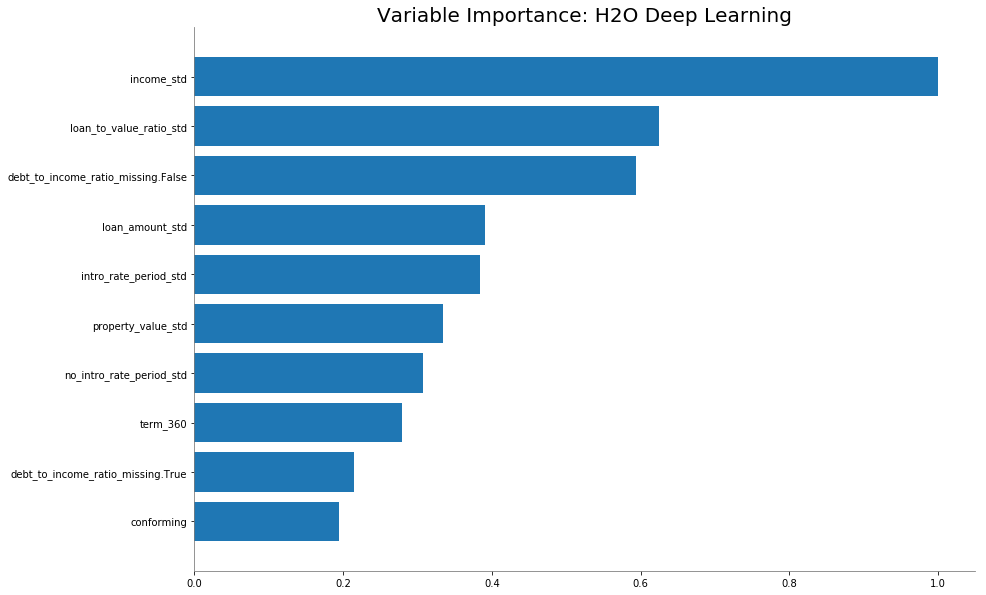

In [17]:
# ANN Var Importance
ann.varimp_plot()

In [20]:
ann_tuned = H2ODeepLearningEstimator(
  model_id="ann_tuned",
  overwrite_with_best_model=False,
  hidden=[128,128,128],            # more hidden layers -> more complex interactions
  epochs=10,                       # to keep it short enough
  score_validation_samples=10000,  # downsample validation set for faster scoring
  score_duty_cycle=0.025,          # don't score more than 2.5% of the wall time
  adaptive_rate=False,             # manually tuned learning rate
  rate=0.01, 
  rate_annealing=0.000002,            
  momentum_start=0.2,              # manually tuned momentum
  momentum_stable=0.4, 
  momentum_ramp=10000000, 
  l1=0.00001,                      # add some L1/L2 regularization
  l2=0.00001,
  max_w2=10.0                        # helps stability for Rectifier
)
ann_tuned.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [22]:
# Get the AUC on the test set for tuned ANN
perf_ann_tuned = ann_tuned.model_performance(test)
print(perf_ann_tuned.auc())

0.8200823543649953


In [23]:
# Get the AUC on 5 fold CV for tuned ANN
perf_cv_ann_tuned = ann_tuned.model_performance(xval=True)
print(perf_cv_ann_tuned.auc())

0.8153425809613689


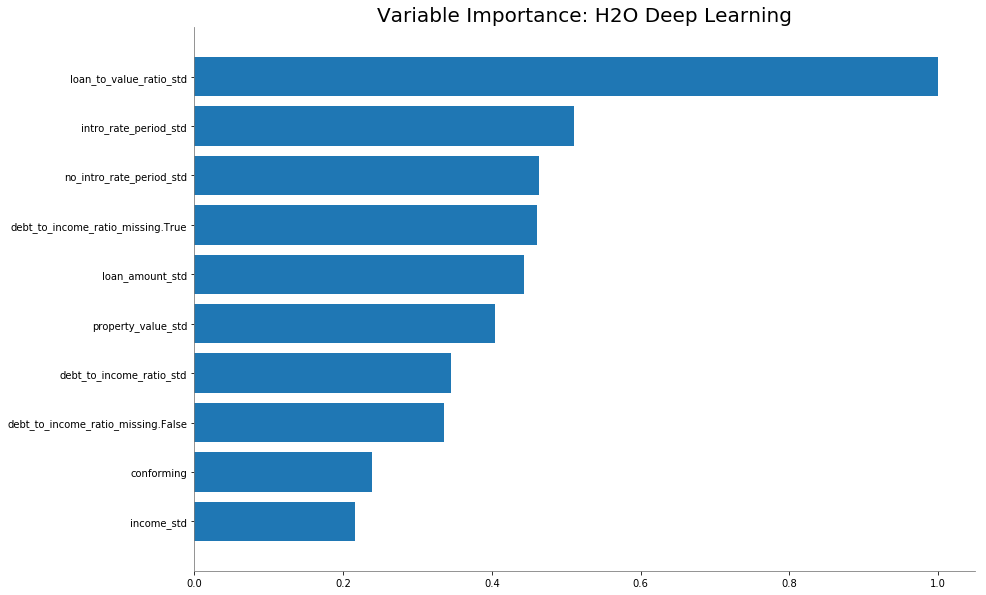

In [24]:
# Tuned ANN Var Importance
ann_tuned.varimp_plot()

## Grid for ANN

In [13]:
hidden_opt = [[17,32],[8,19],[32,16,8],[100],[10,10,10,10]]
l1_opt = [s/1e6 for s in range(1,1001)]
hyper_params = {"hidden":hidden_opt, "l1":l1_opt}
search_criteria = {"strategy":"RandomDiscrete", "max_models":10, "seed": SEED}

model_grid = H2OGridSearch(H2ODeepLearningEstimator,
                           grid_id='ann_grid',
                           hyper_params=hyper_params,
                           search_criteria=search_criteria)

model_grid.train(x=X, 
                 y=Y,
                 distribution="bernoulli",
                 epochs=1000,
                 training_frame=train, 
                 fold_column=fold_column,
                 score_interval=10,
                 stopping_rounds = 5,
                 stopping_metric = "AUC",
                 stopping_tolerance = 1e-4)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [14]:
# Get the grid results, sorted by validation AUC
ann_gridperf = model_grid.get_grid(sort_by='auc', decreasing=True)

In [15]:
print(ann_gridperf)

               hidden       l1          model_ids                 auc
0               [100]  1.28E-4   ann_grid_model_7  0.8070343389830336
1            [17, 32]  4.58E-4   ann_grid_model_9  0.8056910471717147
2            [17, 32]   2.1E-5   ann_grid_model_2  0.8039374960229803
3             [8, 19]  4.21E-4   ann_grid_model_6  0.8026204627009252
4            [17, 32]  2.87E-4   ann_grid_model_3  0.8025769843658054
5         [32, 16, 8]  3.43E-4  ann_grid_model_10  0.8014814782967031
6               [100]  7.12E-4   ann_grid_model_1   0.801128559071046
7         [32, 16, 8]  8.94E-4   ann_grid_model_5  0.8008409371695653
8             [8, 19]  9.27E-4   ann_grid_model_4  0.8001208635506775
9    [10, 10, 10, 10]  8.23E-4   ann_grid_model_8  0.7996175441486854



In [16]:
# Grab the top ANN model, chosen by validation AUC
best_ann = ann_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_ann_perf = best_ann.model_performance(test)

best_ann.auc()

0.7913673320004091

In [88]:
# Save the model
model_path = h2o.save_model(model=best_ann, path="../models/ANN_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/XGB_BEST_GRID_v2_HMDA_1575928848.548365/xgb_grid2_model_11
